### <font color='yellow'>I am something of a Painter Myself</font>


Use GANs to create art - will you be the next Monet?

### <font color='orange'>Dataset</font>

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Check out the CycleGAN dataset to experiment with the artistic style of other artists


In [2]:
BATCH_SIZE = 32

#import dataset from tensorflow, we will deal with tfrecords
import tensorflow as tf
import matplotlib.pyplot as plt

import glob

#load directory of .tfrecords files
print(glob.glob("monet_tfrec/*.tfrec"))
dataset = tf.data.TFRecordDataset(glob.glob("monet_tfrec/*.tfrec"))

#create a parse function
def parse_tfrecord(example):
    features = {"image": tf.io.FixedLenFeature([], tf.string)}
    parsed_features = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(parsed_features['image'])
    image = tf.reshape(image, [256, 256, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return image

parsed_dataset = dataset.map(parse_tfrecord).batch(BATCH_SIZE)

2025-02-21 19:21:59.894453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-21 19:21:59.913186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-21 19:21:59.919263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 19:21:59.933450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['monet_tfrec/monet00-60.tfrec', 'monet_tfrec/monet04-60.tfrec', 'monet_tfrec/monet08-60.tfrec', 'monet_tfrec/monet12-60.tfrec', 'monet_tfrec/monet16-60.tfrec']


2025-02-21 19:22:02.663390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6449 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5
2025-02-21 19:22:02.664159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10177 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


Visualize dataset

2025-02-21 19:22:03.191564: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


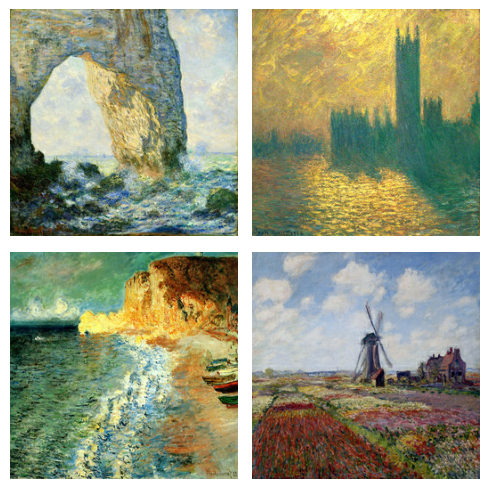

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()

for batch in parsed_dataset.take(1):
    for i, image in enumerate(batch[:4]):
        axes[i].imshow(image)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#I need to first create an encoder that will take the image and encode it into a latent space
#can we use VGG19 as an encoder?

class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
        self.vgg.trainable = False
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x):
        x = self.vgg(x)
        x = self.flatten(x)
        return x

encoder = Encoder()

#test the encoder
image = tf.random.normal([1, 256, 256, 3])
encoded = encoder(image)
print(encoded.shape)

(1, 32768)


We will scale the feature maps based on WEIGHT+BIAS, which will match the style. Style can be seen as a statistics on the feature maps mean and std

In [ ]:
#We will create a IN normalization layer that will normalize the input image

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        self.scale = tf.Variable(1.0, trainable=True)
        self.offset = tf.Variable(0.0, trainable=True)

    def call(self, x):
        mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        variance = tf.reduce_std(x, axis=[1, 2], keepdims=True)
        normalized = (x - mean) / (variance + self.epsilon)
        return normalized * self.scale + self.offset

Now we build a decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        